# Imports

In [ ]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
root_path = 'drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


In [ ]:
import datasets as DS
from datasets import Dataset
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset, TensorDataset
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import to_tensor
from transformers import ViTFeatureExtractor, ViTForImageClassification, AdamW

# Load Dataset

In [ ]:
# Define the path to the image folder and metadata file
image_folder_path = root_path+"/NIH_Chest_XRay/sample/images"
metadata_file_path = root_path+"/NIH_Chest_XRay/sample/images/metadata.jsonl"

# Load the metadata file
data = DS.load_dataset(
    "imagefolder",
    data_dir=image_folder_path,
)

# Split the dataset into train and validation sets
dataset = data["train"]

Resolving data files:   0%|          | 0/5607 [00:00<?, ?it/s]

In [ ]:
# Store the unique labels
unique_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
                 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening',
                 'Pneumonia', 'Pneumothorax']

# Convert one-hot encoded labels to class indices
labels = dataset['labels']
label_data = np.array(labels)
# Calculate class counts
class_counts = np.sum(label_data, axis=0)

num_classes = len(labels[0])

# Print unique labels along with their corresponding sample counts
for label, count in zip(unique_labels, class_counts):
    print(f"{label}: {count} samples")

Atelectasis: 508.0 samples
Cardiomegaly: 141.0 samples
Consolidation: 226.0 samples
Edema: 118.0 samples
Effusion: 644.0 samples
Emphysema: 127.0 samples
Fibrosis: 84.0 samples
Hernia: 13.0 samples
Infiltration: 967.0 samples
Mass: 284.0 samples
No Finding: 3044.0 samples
Nodule: 313.0 samples
Pleural_Thickening: 176.0 samples
Pneumonia: 62.0 samples
Pneumothorax: 271.0 samples


In [ ]:
# Store the unique labels
unique_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
                 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening',
                 'Pneumonia', 'Pneumothorax']

# Convert one-hot encoded labels to class indices
labels = dataset['labels']
label_data = np.array(labels)
# Calculate class counts
class_counts = np.sum(label_data, axis=0)

num_classes = len(labels[0])

# Print unique labels along with their corresponding sample counts
for label, count in zip(unique_labels, class_counts):
    print(f"{label}: {count} samples")

Atelectasis: 508.0 samples
Cardiomegaly: 141.0 samples
Consolidation: 226.0 samples
Edema: 118.0 samples
Effusion: 644.0 samples
Emphysema: 127.0 samples
Fibrosis: 84.0 samples
Hernia: 13.0 samples
Infiltration: 967.0 samples
Mass: 284.0 samples
No Finding: 3044.0 samples
Nodule: 313.0 samples
Pleural_Thickening: 176.0 samples
Pneumonia: 62.0 samples
Pneumothorax: 271.0 samples


**Remove minority labels and samples**

In [ ]:
# Determine classes with less than 50 samples
min_samples = 100
labels_to_drop = [idx for idx, count in enumerate(class_counts) if count < min_samples]

total_length = len(labels[0])
minority_classes = [0 if idx in labels_to_drop else 1 for idx in range(total_length)]

# Print the new list
print(minority_classes)

# Select only few 'No Finding' samples
# Find the label index with the most samples (11th label)
no_finding_index = 10  # Index corresponding to the 11th label
no_finding_samples = 500
no_finding = [idx for idx, label in enumerate(label_data) if label[no_finding_index] == 1]
no_finding_indices = random.sample(no_finding, no_finding_samples)

# Collect indices of label sets that don't have any of the minority classes
indices_without_nofinding = [idx for idx, label in enumerate(label_data) if label[no_finding_index] == 0]
# Get labels
labels_without_nofinding = [label_data[idx] for idx in indices_without_nofinding]

majority_indices = []

for idx, label in enumerate(labels_without_nofinding):
    if label[6] == 0 and label[7] == 0 and label[13] == 0:
        majority_indices.append(idx)

combined_indices = no_finding_indices + majority_indices
# Print the collected indices
print(len(combined_indices))

[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
2904


**Create new dataset with only Selected Samples**

In [ ]:
selected_features = [dataset[idx]['image'] for idx in combined_indices]
selected_labels = [dataset[idx]['labels'] for idx in combined_indices]

# Create new tensors by dropping the specified column
updated_labels = [label[:6] + label[8:13] + label[14:] for label in selected_labels]

selected_dataset = Dataset.from_dict({
    "image": selected_features,
    "labels": updated_labels
    })

# Image Preprocessing

## Preprocess for ViT

**Initialize feature extractor**

In [ ]:
model_ckpt = 'google/vit-base-patch16-224-in21k'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# Preprocess the data for using as input to ViT
vit_features = []
vit_labels = []
for example in selected_dataset:
    image = example["image"]
    image = image.convert("RGB")
    encoded_inputs = extractor(images=image, return_tensors="pt")
    features = encoded_inputs["pixel_values"]
    vit_features.append(features)
    vit_labels.append(example["labels"])

vit_features = torch.cat(vit_features, dim=0)
vit_labels = torch.tensor(vit_labels)

In [ ]:
len(vit_labels)

2904

In [ ]:
#Save the tensors

In [ ]:
#Load the tensors
vit_features_train = torch.load(root_path+'/features/train_features.pt')
vit_labels_train = torch.load(root_path+'/features/train_labels.pt')
vit_features_test = torch.load(root_path+'/features/test_features.pt')
vit_labels_test = torch.load(root_path+'/features/test_labels.pt')

In [ ]:
vit_features_train.shape

torch.Size([4484, 3, 224, 224])

In [ ]:
vit_features = torch.cat((vit_features_train, vit_features_test), dim=0)
vit_labels = torch.cat((vit_labels_train, vit_labels_test), dim=0)

In [ ]:
vit_features.shape

torch.Size([5606, 3, 224, 224])

## Preprocess for CNN

In [ ]:
# Load and preprocess data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Extract features from the dataset
cnn_features = []
cnn_labels = []
for example in selected_dataset:
    image = example["image"]
    image = image.convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension for single image
    cnn_features.append(image)
    cnn_labels.append(example["labels"])

# Convert features and labels to tensors
cnn_features = torch.cat(cnn_features, dim=0)
cnn_labels = torch.tensor(cnn_labels)

#train_dataset_cnn = TensorDataset(train_features, train_labels)
#train_loader = DataLoader(train_dataset_cnn, batch_size=32, shuffle=True)


# Fine-tuning models trained on Dataverse
The base models of ViT and CNN have been fine-tuned the Harvard Dataverse dataset that has around 19000 images for training. It's a multiclass classification problem with 5 classes. We use this fine-tuned model and try to fine-tune it further for NIH dataset

## Further fine-tune ViT fine-tuned on Dataverse

In [ ]:
# Load the feature tensors
train_features = torch.load(root_path+"features/train_features.pt")
train_labels = torch.load(root_path+"features/train_labels.pt")

test_features = torch.load(root_path+"features/test_features.pt")
test_labels = torch.load(root_path+"features/test_labels.pt")

In [ ]:
len(train_labels)

4484

In [ ]:
vit_features = torch.cat((train_features, test_features), dim=0)
vit_labels = torch.cat((train_labels, test_labels), dim=0)

# Feature Extraction from Fine-tuned Models

## Vision Transformer

In [ ]:
# Define Hyperparameters
NUM_CLASSES = len(vit_labels[0])
BATCH_SIZE = 32

# Load pretrained ViT model
vit_dir = root_path+'/vit_pretrained_dataverse'
model = ViTForImageClassification.from_pretrained(vit_dir, ignore_mismatched_sizes=True)

# Modify the output layer for multilabel classification
model.classifier = nn.Linear(model.config.hidden_size, NUM_CLASSES)

# Initialize the Dataloader
vit_features = vit_features.to(device)
vit_labels = vit_labels.to(device)

vit_dataset = TensorDataset(vit_features, vit_labels)
vit_dataloader = DataLoader(vit_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Move the model and data to GPU if available
model.to(device)
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
# Access the base model (Vision Transformer without classification head)
base_model = model.base_model

all_features_vit = []
# Loop through the data and extract features
with torch.no_grad():
    for batch_images, _ in vit_dataloader:
        batch_images = batch_images.to(device)

        # Forward pass through the base model
        outputs = base_model(batch_images)

        # Extract the features (change the indexing if needed)
        extracted_features = outputs.last_hidden_state[:, 1:-1, :]  # Exclude CLS and SEP tokens

        # Append to the list
        all_features_vit.append(extracted_features)

# Concatenate the list of feature tensors
all_features_vit = torch.cat(all_features_vit, dim=0)


In [ ]:
# Save features for class-balanced dataset
#torch.save(all_features_vit, root_path+'/features/vit_features_selected.pt')
#torch.save(vit_labels, root_path+'/features/vit_labels_selected.pt')

In [ ]:
# Load features of the class-balanced dataset
all_features_vit = torch.load(root_path+'/features/vit_features_selected.pt')
vit_labels = torch.load(root_path+'/features/vit_labels_selected.pt')

In [ ]:
# Save features for the whole NIH dataset
#torch.save(all_features_vit, root_path+'/features/vit_features_original.pt')
#torch.save(vit_labels, root_path+'/features/vit_labels_original.pt')

In [ ]:
# Load features of the whole NIH dataset
all_features_vit = torch.load(root_path+'/features/vit_features_original.pt')
vit_labels = torch.load(root_path+'/features/vit_labels_original.pt')

## CNN features (MobileNet)

The MobileNet model used here has been fine-tuned on Harvard Dataverse dataset

In [ ]:
# Load the MobileNet model architecture
mobilenet = models.mobilenet_v2(pretrained=False)

# Modify the classifier to match the number of classes in your task
num_classes = 5  # Change this to the number of your classes
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, num_classes)

# Load the fine-tuned weights
model_path = root_path+'mobilenet_dataverse/mobilenet_model.pth'
mobilenet.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Remove the classification head (fully connected layers)
mobilenet = nn.Sequential(*list(mobilenet.children())[:-1])  # Remove the last layer

# Initialize the Dataloader
cnn_dataset = TensorDataset(cnn_features, cnn_labels)
cnn_dataloader = DataLoader(cnn_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Set the model to evaluation mode
mobilenet.eval()

In [ ]:
# Extract features from fine-tuned MobileNet
all_feature_cnn = []

with torch.no_grad():
    for batch_images, _ in cnn_dataloader:
        features = mobilenet(batch_images)
        all_feature_cnn.append(features)

# Concatenate the features along the batch dimension
all_feature_cnn = torch.cat(all_feature_cnn, dim=0)

In [ ]:
# Save features
torch.save(all_feature_cnn, root_path+'/features/cnn_features_selected.pt')
torch.save(cnn_labels, root_path+'/features/cnn_labels_selected.pt')

In [ ]:
# Load features
all_feature_cnn = torch.load(root_path+'/features/cnn_features_selected.pt')
cnn_labels = torch.load(root_path+'/features/cnn_labels_selected.pt')

# Classifier

In [ ]:
BATCH_SIZE = 32

## Approach 1 : Combine ViT and CNN

In [ ]:
# Flatten features
vit_features_reshaped = all_features_vit.reshape(all_features_vit.shape[0], -1)
cnn_features_reshaped = all_feature_cnn.reshape(all_feature_cnn.shape[0], -1)

all_features = torch.cat((vit_features_reshaped, cnn_features_reshaped), dim=1)
# Convert feature_tensor and label_tensor to NumPy arrays
feature_array = all_features.cpu().numpy()
label_array = vit_labels.cpu().numpy()

# Split the data into train and test sets
# You can adjust the test_size and random_state parameters as needed
X_train, X_test, y_train, y_test = train_test_split(feature_array, label_array, test_size=0.2, random_state=42)


In [ ]:
# Define your neural network architecture
class MultiLabelClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiLabelClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

# Create the model
model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Convert X_train_reshaped and y_train to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Train the model
num_epochs = 10
batch_size = BATCH_SIZE

# Initialize lists to store metrics over 10 runs
average_train_losses = []
average_test_losses = []
average_accuracies = []
average_f1_scores = []
average_auc_rocs = []

for run in range(10):  # Perform 10 runs
    train_losses = []
    test_losses = []
    accuracies = []
    f1_scores = []
    auc_rocs = []
    # Initialize the model
    model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))
    # Define loss and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    print(f"Run : {run+1}")
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * batch_X.size(0)

        # Calculate average training loss for the epoch
        epoch_train_loss = running_train_loss / len(y_train_tensor)
        train_losses.append(epoch_train_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}")

        # Evaluation Loop
        running_test_loss = 0.0
        all_preds = []
        all_labels = []
        model.eval()
        with torch.no_grad():
            for i in range(0, len(X_test_tensor), batch_size):
                batch_X = X_test_tensor[i:i+batch_size]
                batch_y = y_test_tensor[i:i+batch_size]

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                running_test_loss += loss.item() * batch_X.size(0)

                # Convert predictions and labels to numpy arrays
                batch_preds = outputs.cpu().numpy()
                batch_labels = batch_y.cpu().numpy()

                all_preds.append(batch_preds)
                all_labels.append(batch_labels)

        #test_loss = running_test_loss / len(X_test_tensor)
        epoch_test_loss = running_test_loss / len(y_test_tensor)
        test_losses.append(epoch_test_loss)

        # Calculate accuracy and AUC ROC for the test set
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        all_pred_labels = (all_preds > 0.5).astype(int)
        test_accuracy = accuracy_score(all_labels, all_pred_labels)
        test_auc_roc = roc_auc_score(all_labels, all_preds)

        # Calculate F1-Score
        f1 = f1_score(all_labels, all_pred_labels, average='micro')

        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC ROC: {test_auc_roc:.4f}, F1-Score : {f1:.4f}")

    # At the end of each run, append metrics to the respective lists
    average_train_losses.append(train_losses)
    average_test_losses.append(test_losses)
    average_accuracies.append(test_accuracy)
    average_f1_scores.append(f1)
    average_auc_rocs.append(test_auc_roc)


# Calculate the average and standard deviation for each metric
avg_train_loss = np.mean(average_train_losses)
std_train_loss = np.std(average_train_losses)
avg_test_loss = np.mean(average_test_losses)
std_test_loss = np.std(average_test_losses)
avg_accuracy = np.mean(average_accuracies)
std_accuracy = np.std(average_accuracies)
avg_f1_score = np.mean(average_f1_scores)
std_f1_score = np.std(average_f1_scores)
avg_auc_roc = np.mean(average_auc_rocs)
std_auc_roc = np.std(average_auc_rocs)

# Print the average and standard deviation values
print(f"Average Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f} ± {std_f1_score:.4f}")
print(f"Average AUC ROC: {avg_auc_roc:.4f} ± {std_auc_roc:.4f}")

Run : 1
Epoch [1/10], Train Loss: 0.2743
Test Loss: 0.1523, Test Accuracy: 0.6644, Test AUC ROC: 0.8678, F1-Score : 0.7365
Epoch [2/10], Train Loss: 0.1453
Test Loss: 0.1380, Test Accuracy: 0.7005, Test AUC ROC: 0.8896, F1-Score : 0.7523
Epoch [3/10], Train Loss: 0.1296
Test Loss: 0.1314, Test Accuracy: 0.7126, Test AUC ROC: 0.8904, F1-Score : 0.7556
Epoch [4/10], Train Loss: 0.1202
Test Loss: 0.1283, Test Accuracy: 0.7143, Test AUC ROC: 0.8829, F1-Score : 0.7641
Epoch [5/10], Train Loss: 0.1130
Test Loss: 0.1263, Test Accuracy: 0.7229, Test AUC ROC: 0.8816, F1-Score : 0.7690
Epoch [6/10], Train Loss: 0.1074
Test Loss: 0.1247, Test Accuracy: 0.7246, Test AUC ROC: 0.8822, F1-Score : 0.7705
Epoch [7/10], Train Loss: 0.1020
Test Loss: 0.1249, Test Accuracy: 0.7281, Test AUC ROC: 0.8834, F1-Score : 0.7751
Epoch [8/10], Train Loss: 0.0970
Test Loss: 0.1254, Test Accuracy: 0.7194, Test AUC ROC: 0.8904, F1-Score : 0.7716
Epoch [9/10], Train Loss: 0.0921
Test Loss: 0.1265, Test Accuracy: 0.721

In [ ]:
# Train the model
num_epochs = 10
batch_size = BATCH_SIZE

# Initialize lists to store metrics over 10 runs
average_train_losses = []
average_test_losses = []
average_accuracies = []
average_f1_scores = []
average_auc_rocs = []

for run in range(10):  # Perform 10 runs
    train_losses = []
    test_losses = []
    accuracies = []
    f1_scores = []
    auc_rocs = []

    for epoch in range(num_epochs):
        running_train_loss = 0.0
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * batch_X.size(0)

        # Calculate average training loss for the epoch
        epoch_train_loss = running_train_loss / len(y_train_tensor)
        train_losses.append(epoch_train_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}")

        running_test_loss = 0.0
        all_preds = []
        all_labels = []
        model.eval()
        with torch.no_grad():
            for i in range(0, len(X_test_tensor), batch_size):
                batch_X = X_test_tensor[i:i+batch_size]
                batch_y = y_test_tensor[i:i+batch_size]

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                running_test_loss += loss.item() * batch_X.size(0)

                # Convert predictions and labels to numpy arrays
                batch_preds = outputs.cpu().numpy()
                batch_labels = batch_y.cpu().numpy()

                all_preds.append(batch_preds)
                all_labels.append(batch_labels)

        # Calculate average test loss for the epoch
        epoch_test_loss = running_test_loss / len(X_test_tensor)
        test_losses.append(epoch_test_loss)

        # Calculate accuracy and AUC ROC for the test set
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        all_pred_labels = (all_preds > 0.5).astype(int)
        test_accuracy = accuracy_score(all_labels, all_pred_labels)
        test_auc_roc = roc_auc_score(all_labels, all_preds)

        # Calculate F1-Score (micro-averaged)
        f1 = f1_score(all_labels, all_pred_labels, average='micro')

        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC ROC: {test_auc_roc:.4f}, F1-Score : {f1:.4f}")

    # At the end of each run, append metrics to the respective lists
    average_train_losses.append(train_losses)
    average_test_losses.append(test_losses)
    average_accuracies.append(accuracies)
    average_f1_scores.append(f1_scores)
    average_auc_rocs.append(auc_rocs)


# Calculate the average and standard deviation for each metric
avg_train_loss = np.mean(average_train_losses)
std_train_loss = np.std(average_train_losses)
avg_test_loss = np.mean(average_test_losses)
std_test_loss = np.std(average_test_losses)
avg_accuracy = np.mean(average_accuracies)
std_accuracy = np.std(average_accuracies)
avg_f1_score = np.mean(average_f1_scores)
std_f1_score = np.std(average_f1_scores)
avg_auc_roc = np.mean(average_auc_rocs)
std_auc_roc = np.std(average_auc_rocs)

# Print the average and standard deviation values
print(f"Average Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f} ± {std_f1_score:.4f}")
print(f"Average AUC ROC: {avg_auc_roc:.4f} ± {std_auc_roc:.4f}")

Epoch [1/10], Train Loss: 0.3372
Test Loss: 0.1961, Test Accuracy: 0.6885, Test AUC ROC: 0.8850, F1-Score (Micro): 0.7392, F1-Score (Macro): 0.2427
Epoch [2/10], Train Loss: 0.1560
Test Loss: 0.1344, Test Accuracy: 0.7212, Test AUC ROC: 0.9056, F1-Score (Micro): 0.7668, F1-Score (Macro): 0.2984
Epoch [3/10], Train Loss: 0.1236
Test Loss: 0.1271, Test Accuracy: 0.7401, Test AUC ROC: 0.9116, F1-Score (Micro): 0.7818, F1-Score (Macro): 0.3581
Epoch [4/10], Train Loss: 0.1131
Test Loss: 0.1242, Test Accuracy: 0.7332, Test AUC ROC: 0.9129, F1-Score (Micro): 0.7778, F1-Score (Macro): 0.3560
Epoch [5/10], Train Loss: 0.1058
Test Loss: 0.1237, Test Accuracy: 0.7367, Test AUC ROC: 0.9122, F1-Score (Micro): 0.7788, F1-Score (Macro): 0.3597
Epoch [6/10], Train Loss: 0.1003
Test Loss: 0.1230, Test Accuracy: 0.7418, Test AUC ROC: 0.9116, F1-Score (Micro): 0.7755, F1-Score (Macro): 0.3533
Epoch [7/10], Train Loss: 0.0952
Test Loss: 0.1228, Test Accuracy: 0.7332, Test AUC ROC: 0.9111, F1-Score (Micro

In [ ]:
test_precision = precision_score(all_labels, all_pred_labels, average='micro')  # You can choose 'micro', 'macro', 'weighted', or 'samples'
test_recall = recall_score(all_labels, all_pred_labels, average='micro')  # You can choose 'micro', 'macro', 'weighted', or 'samples'
print(test_precision)
print(test_recall)

0.8281786941580757
0.7259036144578314


In [ ]:
# Save model
torch.save(model.state_dict(), root_path+'final_models/vit_cnn_approach1.pth')

## Approach 2

### Classifier trained on ViT Features

In [ ]:
# Load features of ORIGINAL DATASET
#all_features_vit = torch.load(root_path+'/features/train_features.pt')
#vit_labels = torch.load(root_path+'/features/train_labels.pt')

In [ ]:
# Flatten features
vit_features_reshaped = all_features_vit.reshape(all_features_vit.shape[0], -1)

# Convert feature_tensor and label_tensor to NumPy arrays
feature_array = vit_features_reshaped.cpu().numpy()
label_array = vit_labels.cpu().numpy()

# Split the data into train and test sets
# You can adjust the test_size and random_state parameters as needed
X_train, X_test, y_train, y_test = train_test_split(feature_array, label_array, test_size=0.2, random_state=42)


In [ ]:
all_features_vit.shape

torch.Size([2904, 195, 768])

#### NIH Original dataset

In [ ]:
# Define your neural network architecture
class MultiLabelClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiLabelClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)  # Output layer
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))  # Apply ReLU activation for the third hidden layer
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

# Create the model
model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Convert X_train and y_train to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Train the model
num_epochs = 10
batch_size = BATCH_SIZE

# Initialize lists to store metrics over 10 runs
average_train_losses = []
average_test_losses = []
average_accuracies = []
average_f1_scores = []
average_auc_rocs = []

for run in range(10):  # Perform 10 runs
    train_losses = []
    test_losses = []
    accuracies = []
    f1_scores = []
    auc_rocs = []
    # Initialize the model
    model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))
    # Define loss and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    print(f"Run : {run+1}")
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * batch_X.size(0)

        # Calculate average training loss for the epoch
        epoch_train_loss = running_train_loss / len(y_train_tensor)
        train_losses.append(epoch_train_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}")

        # Evaluation Loop
        running_test_loss = 0.0
        all_preds = []
        all_labels = []
        model.eval()
        with torch.no_grad():
            for i in range(0, len(X_test_tensor), batch_size):
                batch_X = X_test_tensor[i:i+batch_size]
                batch_y = y_test_tensor[i:i+batch_size]

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                running_test_loss += loss.item() * batch_X.size(0)

                # Convert predictions and labels to numpy arrays
                batch_preds = outputs.cpu().numpy()
                batch_labels = batch_y.cpu().numpy()

                all_preds.append(batch_preds)
                all_labels.append(batch_labels)

        #test_loss = running_test_loss / len(X_test_tensor)
        epoch_test_loss = running_test_loss / len(y_test_tensor)
        test_losses.append(epoch_test_loss)

        # Calculate accuracy and AUC ROC for the test set
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        all_pred_labels = (all_preds > 0.5).astype(int)
        test_accuracy = accuracy_score(all_labels, all_pred_labels)
        test_auc_roc = roc_auc_score(all_labels, all_preds)

        # Calculate F1-Score
        f1 = f1_score(all_labels, all_pred_labels, average='micro')

        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC ROC: {test_auc_roc:.4f}, F1-Score : {f1:.4f}")

    # At the end of each run, append metrics to the respective lists
    average_train_losses.append(train_losses)
    average_test_losses.append(test_losses)
    average_accuracies.append(test_accuracy)
    average_f1_scores.append(f1)
    average_auc_rocs.append(test_auc_roc)


# Calculate the average and standard deviation for each metric
avg_train_loss = np.mean(average_train_losses)
std_train_loss = np.std(average_train_losses)
avg_test_loss = np.mean(average_test_losses)
std_test_loss = np.std(average_test_losses)
avg_accuracy = np.mean(average_accuracies)
std_accuracy = np.std(average_accuracies)
avg_f1_score = np.mean(average_f1_scores)
std_f1_score = np.std(average_f1_scores)
avg_auc_roc = np.mean(average_auc_rocs)
std_auc_roc = np.std(average_auc_rocs)

# Print the average and standard deviation values
print(f"Average Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f} ± {std_f1_score:.4f}")
print(f"Average AUC ROC: {avg_auc_roc:.4f} ± {std_auc_roc:.4f}")

Run : 1
Epoch [1/10], Train Loss: 0.3319
Test Loss: 0.2200, Test Accuracy: 0.4643, Test AUC ROC: 0.7784, F1-Score : 0.5882
Epoch [2/10], Train Loss: 0.1627
Test Loss: 0.1380, Test Accuracy: 0.5152, Test AUC ROC: 0.8541, F1-Score : 0.6493
Epoch [3/10], Train Loss: 0.1274
Test Loss: 0.1256, Test Accuracy: 0.6444, Test AUC ROC: 0.8697, F1-Score : 0.7148
Epoch [4/10], Train Loss: 0.1173
Test Loss: 0.1207, Test Accuracy: 0.6551, Test AUC ROC: 0.8712, F1-Score : 0.7253
Epoch [5/10], Train Loss: 0.1120
Test Loss: 0.1185, Test Accuracy: 0.6586, Test AUC ROC: 0.8713, F1-Score : 0.7297
Epoch [6/10], Train Loss: 0.1081
Test Loss: 0.1171, Test Accuracy: 0.6658, Test AUC ROC: 0.8782, F1-Score : 0.7338
Epoch [7/10], Train Loss: 0.1050
Test Loss: 0.1160, Test Accuracy: 0.6676, Test AUC ROC: 0.8789, F1-Score : 0.7365
Epoch [8/10], Train Loss: 0.1022
Test Loss: 0.1154, Test Accuracy: 0.6720, Test AUC ROC: 0.8798, F1-Score : 0.7406
Epoch [9/10], Train Loss: 0.0996
Test Loss: 0.1143, Test Accuracy: 0.673

In [ ]:
val_precision = precision_score(all_labels, all_pred_labels, average='micro')
val_recall = recall_score(all_labels, all_pred_labels, average='micro')
print(val_precision)
print(val_recall)

0.823943661971831
0.6772793053545586


In [ ]:
# Convert the main_list to a NumPy array for efficient calculations
trainlosses_array = np.array(average_train_losses)
testlosses_array = np.array(average_test_losses)

# Calculate the average along the first axis (axis=0) to get the average of each element position
train_avg_across_runs = np.mean(trainlosses_array, axis=0)
test_avg_across_runs = np.mean(testlosses_array, axis=0)

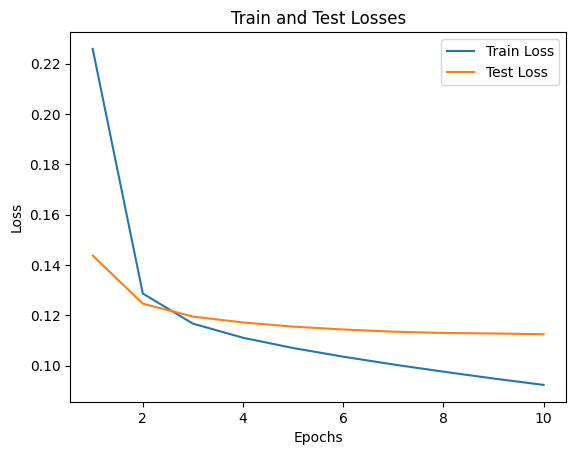

In [ ]:
# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot train losses
plt.plot(epochs, train_avg_across_runs, label='Train Loss')
# Plot test losses
plt.plot(epochs, test_avg_across_runs, label='Test Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()  # Show legend

# Display the plot
plt.show()

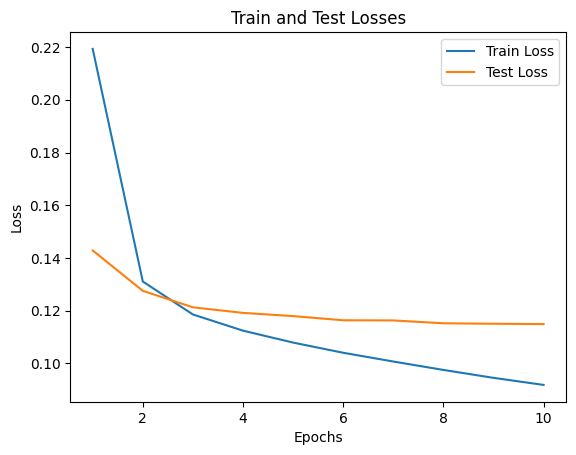

In [ ]:
# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot train losses
plt.plot(epochs, train_losses, label='Train Loss')
# Plot test losses
plt.plot(epochs, test_losses, label='Test Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()  # Show legend

# Display the plot
plt.show()

In [ ]:
# Save model
torch.save(model.state_dict(), root_path+'final_models/vit_approach2_original.pth')

#### NIH Class-Balanced Dataset

In [ ]:
# Define your neural network architecture
class MultiLabelClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiLabelClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)  # Output layer
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))  # Apply ReLU activation for the third hidden layer
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

# Create the model
model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Convert X_train and y_train to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Train the model
num_epochs = 20
batch_size = BATCH_SIZE

# Initialize lists to store metrics over 10 runs
average_train_losses = []
average_test_losses = []
average_accuracies = []
average_f1_scores = []
average_auc_rocs = []

for run in range(10):  # Perform 10 runs
    train_losses = []
    test_losses = []
    accuracies = []
    f1_scores = []
    auc_rocs = []
    # Initialize the model
    model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))
    # Define loss and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    print(f"Run : {run+1}")
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * batch_X.size(0)

        # Calculate average training loss for the epoch
        epoch_train_loss = running_train_loss / len(y_train_tensor)
        train_losses.append(epoch_train_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}")

        # Evaluation Loop
        running_test_loss = 0.0
        all_preds = []
        all_labels = []
        model.eval()
        with torch.no_grad():
            for i in range(0, len(X_test_tensor), batch_size):
                batch_X = X_test_tensor[i:i+batch_size]
                batch_y = y_test_tensor[i:i+batch_size]

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                running_test_loss += loss.item() * batch_X.size(0)

                # Convert predictions and labels to numpy arrays
                batch_preds = outputs.cpu().numpy()
                batch_labels = batch_y.cpu().numpy()

                all_preds.append(batch_preds)
                all_labels.append(batch_labels)

        #test_loss = running_test_loss / len(X_test_tensor)
        epoch_test_loss = running_test_loss / len(y_test_tensor)
        test_losses.append(epoch_test_loss)

        # Calculate accuracy and AUC ROC for the test set
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        all_pred_labels = (all_preds > 0.5).astype(int)
        test_accuracy = accuracy_score(all_labels, all_pred_labels)
        test_auc_roc = roc_auc_score(all_labels, all_preds)

        # Calculate F1-Score
        f1 = f1_score(all_labels, all_pred_labels, average='micro')

        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC ROC: {test_auc_roc:.4f}, F1-Score : {f1:.4f}")

    # At the end of each run, append metrics to the respective lists
    average_train_losses.append(train_losses)
    average_test_losses.append(test_losses)
    average_accuracies.append(test_accuracy)
    average_f1_scores.append(f1)
    average_auc_rocs.append(test_auc_roc)


# Calculate the average and standard deviation for each metric
avg_train_loss = np.mean(average_train_losses)
std_train_loss = np.std(average_train_losses)
avg_test_loss = np.mean(average_test_losses)
std_test_loss = np.std(average_test_losses)
avg_accuracy = np.mean(average_accuracies)
std_accuracy = np.std(average_accuracies)
avg_f1_score = np.mean(average_f1_scores)
std_f1_score = np.std(average_f1_scores)
avg_auc_roc = np.mean(average_auc_rocs)
std_auc_roc = np.std(average_auc_rocs)

# Print the average and standard deviation values
print(f"Average Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f} ± {std_f1_score:.4f}")
print(f"Average AUC ROC: {avg_auc_roc:.4f} ± {std_auc_roc:.4f}")

Run : 1
Epoch [1/20], Train Loss: 0.3274
Test Loss: 0.2106, Test Accuracy: 0.6506, Test AUC ROC: 0.8896, F1-Score : 0.6231
Epoch [2/20], Train Loss: 0.1684
Test Loss: 0.1384, Test Accuracy: 0.6867, Test AUC ROC: 0.8967, F1-Score : 0.7572
Epoch [3/20], Train Loss: 0.1323
Test Loss: 0.1284, Test Accuracy: 0.6971, Test AUC ROC: 0.9040, F1-Score : 0.7616
Epoch [4/20], Train Loss: 0.1219
Test Loss: 0.1230, Test Accuracy: 0.7074, Test AUC ROC: 0.9076, F1-Score : 0.7691
Epoch [5/20], Train Loss: 0.1146
Test Loss: 0.1197, Test Accuracy: 0.7108, Test AUC ROC: 0.9113, F1-Score : 0.7741
Epoch [6/20], Train Loss: 0.1090
Test Loss: 0.1184, Test Accuracy: 0.7212, Test AUC ROC: 0.9122, F1-Score : 0.7828
Epoch [7/20], Train Loss: 0.1041
Test Loss: 0.1172, Test Accuracy: 0.7212, Test AUC ROC: 0.9139, F1-Score : 0.7831
Epoch [8/20], Train Loss: 0.1000
Test Loss: 0.1165, Test Accuracy: 0.7229, Test AUC ROC: 0.9154, F1-Score : 0.7838
Epoch [9/20], Train Loss: 0.0961
Test Loss: 0.1161, Test Accuracy: 0.726

In [ ]:
# Train the model
num_epochs = 10
batch_size = BATCH_SIZE

# Initialize lists to store metrics over 10 runs
average_train_losses = []
average_test_losses = []
average_accuracies = []
average_f1_scores = []
average_auc_rocs = []

for run in range(10):  # Perform 10 runs
    train_losses = []
    test_losses = []
    accuracies = []
    f1_scores = []
    auc_rocs = []
    # Initialize the model
    model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))
    # Define loss and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    print(f"Run : {run+1}")
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * batch_X.size(0)

        # Calculate average training loss for the epoch
        epoch_train_loss = running_train_loss / len(y_train_tensor)
        train_losses.append(epoch_train_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}")

        # Evaluation Loop
        running_test_loss = 0.0
        all_preds = []
        all_labels = []
        model.eval()
        with torch.no_grad():
            for i in range(0, len(X_test_tensor), batch_size):
                batch_X = X_test_tensor[i:i+batch_size]
                batch_y = y_test_tensor[i:i+batch_size]

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                running_test_loss += loss.item() * batch_X.size(0)

                # Convert predictions and labels to numpy arrays
                batch_preds = outputs.cpu().numpy()
                batch_labels = batch_y.cpu().numpy()

                all_preds.append(batch_preds)
                all_labels.append(batch_labels)

        #test_loss = running_test_loss / len(X_test_tensor)
        epoch_test_loss = running_test_loss / len(y_test_tensor)
        test_losses.append(epoch_test_loss)

        # Calculate accuracy and AUC ROC for the test set
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        all_pred_labels = (all_preds > 0.5).astype(int)
        test_accuracy = accuracy_score(all_labels, all_pred_labels)
        test_auc_roc = roc_auc_score(all_labels, all_preds)

        # Calculate F1-Score
        f1 = f1_score(all_labels, all_pred_labels, average='micro')

        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC ROC: {test_auc_roc:.4f}, F1-Score : {f1:.4f}")

    # At the end of each run, append metrics to the respective lists
    average_train_losses.append(train_losses)
    average_test_losses.append(test_losses)
    average_accuracies.append(test_accuracy)
    average_f1_scores.append(f1)
    average_auc_rocs.append(test_auc_roc)


# Calculate the average and standard deviation for each metric
avg_train_loss = np.mean(average_train_losses)
std_train_loss = np.std(average_train_losses)
avg_test_loss = np.mean(average_test_losses)
std_test_loss = np.std(average_test_losses)
avg_accuracy = np.mean(average_accuracies)
std_accuracy = np.std(average_accuracies)
avg_f1_score = np.mean(average_f1_scores)
std_f1_score = np.std(average_f1_scores)
avg_auc_roc = np.mean(average_auc_rocs)
std_auc_roc = np.std(average_auc_rocs)

# Print the average and standard deviation values
print(f"Average Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f} ± {std_f1_score:.4f}")
print(f"Average AUC ROC: {avg_auc_roc:.4f} ± {std_auc_roc:.4f}")

Run : 1
Epoch [1/10], Train Loss: 0.2293
Test Loss: 0.1467, Test Accuracy: 0.6988, Test AUC ROC: 0.8942, F1-Score : 0.7371
Epoch [2/10], Train Loss: 0.1460
Test Loss: 0.1326, Test Accuracy: 0.7005, Test AUC ROC: 0.9057, F1-Score : 0.7487
Epoch [3/10], Train Loss: 0.1305
Test Loss: 0.1236, Test Accuracy: 0.7160, Test AUC ROC: 0.9124, F1-Score : 0.7684
Epoch [4/10], Train Loss: 0.1187
Test Loss: 0.1183, Test Accuracy: 0.7126, Test AUC ROC: 0.9147, F1-Score : 0.7704
Epoch [5/10], Train Loss: 0.1106
Test Loss: 0.1155, Test Accuracy: 0.7246, Test AUC ROC: 0.9169, F1-Score : 0.7768
Epoch [6/10], Train Loss: 0.1040
Test Loss: 0.1145, Test Accuracy: 0.7246, Test AUC ROC: 0.9177, F1-Score : 0.7804
Epoch [7/10], Train Loss: 0.0984
Test Loss: 0.1137, Test Accuracy: 0.7281, Test AUC ROC: 0.9187, F1-Score : 0.7885
Epoch [8/10], Train Loss: 0.0934
Test Loss: 0.1138, Test Accuracy: 0.7281, Test AUC ROC: 0.9193, F1-Score : 0.7876
Epoch [9/10], Train Loss: 0.0888
Test Loss: 0.1135, Test Accuracy: 0.734

In [ ]:
# Train the model
num_epochs = 10
batch_size = BATCH_SIZE

# Initialize lists to store metrics over 10 runs
average_train_losses = []
average_test_losses = []
average_accuracies = []
average_f1_scores = []
average_auc_rocs = []

for run in range(10):  # Perform 10 runs
    train_losses = []
    test_losses = []
    accuracies = []
    f1_scores = []
    auc_rocs = []
    # Initialize the model
    model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))
    # Define loss and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    print(f"Run : {run+1}")
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * batch_X.size(0)

        # Calculate average training loss for the epoch
        epoch_train_loss = running_train_loss / len(y_train_tensor)
        train_losses.append(epoch_train_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}")

        # Evaluation Loop
        running_test_loss = 0.0
        all_preds = []
        all_labels = []
        model.eval()
        with torch.no_grad():
            for i in range(0, len(X_test_tensor), batch_size):
                batch_X = X_test_tensor[i:i+batch_size]
                batch_y = y_test_tensor[i:i+batch_size]

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                running_test_loss += loss.item() * batch_X.size(0)

                # Convert predictions and labels to numpy arrays
                batch_preds = outputs.cpu().numpy()
                batch_labels = batch_y.cpu().numpy()

                all_preds.append(batch_preds)
                all_labels.append(batch_labels)

        #test_loss = running_test_loss / len(X_test_tensor)
        epoch_test_loss = running_test_loss / len(y_test_tensor)
        test_losses.append(epoch_test_loss)

        # Calculate accuracy and AUC ROC for the test set
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        all_pred_labels = (all_preds > 0.5).astype(int)
        test_accuracy = accuracy_score(all_labels, all_pred_labels)
        test_auc_roc = roc_auc_score(all_labels, all_preds)

        # Calculate F1-Score
        f1 = f1_score(all_labels, all_pred_labels, average='micro')

        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC ROC: {test_auc_roc:.4f}, F1-Score : {f1:.4f}")

    # At the end of each run, append metrics to the respective lists
    average_train_losses.append(train_losses)
    average_test_losses.append(test_losses)
    average_accuracies.append(test_accuracy)
    average_f1_scores.append(f1)
    average_auc_rocs.append(test_auc_roc)


# Calculate the average and standard deviation for each metric
avg_train_loss = np.mean(average_train_losses)
std_train_loss = np.std(average_train_losses)
avg_test_loss = np.mean(average_test_losses)
std_test_loss = np.std(average_test_losses)
avg_accuracy = np.mean(average_accuracies)
std_accuracy = np.std(average_accuracies)
avg_f1_score = np.mean(average_f1_scores)
std_f1_score = np.std(average_f1_scores)
avg_auc_roc = np.mean(average_auc_rocs)
std_auc_roc = np.std(average_auc_rocs)

# Print the average and standard deviation values
print(f"Average Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f} ± {std_f1_score:.4f}")
print(f"Average AUC ROC: {avg_auc_roc:.4f} ± {std_auc_roc:.4f}")

Run : 1
Epoch [1/10], Train Loss: 0.3564
Test Loss: 0.1455, Test Accuracy: 0.6661, Test AUC ROC: 0.8989, F1-Score : 0.7219
Epoch [2/10], Train Loss: 0.1351
Test Loss: 0.1225, Test Accuracy: 0.7194, Test AUC ROC: 0.9129, F1-Score : 0.7647
Epoch [3/10], Train Loss: 0.1214
Test Loss: 0.1164, Test Accuracy: 0.7349, Test AUC ROC: 0.9158, F1-Score : 0.7880
Epoch [4/10], Train Loss: 0.1147
Test Loss: 0.1146, Test Accuracy: 0.7418, Test AUC ROC: 0.9187, F1-Score : 0.7894
Epoch [5/10], Train Loss: 0.1099
Test Loss: 0.1129, Test Accuracy: 0.7453, Test AUC ROC: 0.9208, F1-Score : 0.7931
Epoch [6/10], Train Loss: 0.1056
Test Loss: 0.1117, Test Accuracy: 0.7470, Test AUC ROC: 0.9218, F1-Score : 0.7918
Epoch [7/10], Train Loss: 0.1017
Test Loss: 0.1110, Test Accuracy: 0.7487, Test AUC ROC: 0.9216, F1-Score : 0.7941
Epoch [8/10], Train Loss: 0.0979
Test Loss: 0.1105, Test Accuracy: 0.7522, Test AUC ROC: 0.9228, F1-Score : 0.7938
Epoch [9/10], Train Loss: 0.0943
Test Loss: 0.1101, Test Accuracy: 0.748

In [ ]:
# Convert the main_list to a NumPy array for efficient calculations
trainlosses_array = np.array(average_train_losses)
testlosses_array = np.array(average_test_losses)

# Calculate the average along the first axis (axis=0) to get the average of each element position
train_avg_across_runs = np.mean(trainlosses_array, axis=0)
test_avg_across_runs = np.mean(testlosses_array, axis=0)

In [ ]:
val_precision = precision_score(all_labels, all_pred_labels, average='micro')
val_recall = recall_score(all_labels, all_pred_labels, average='micro')
print(val_precision)
print(val_recall)

0.8503521126760564
0.7274096385542169


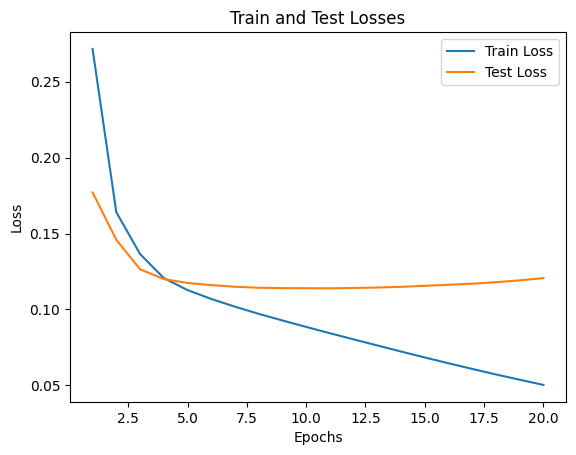

In [ ]:
# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot train losses
plt.plot(epochs, train_avg_across_runs, label='Train Loss')
# Plot test losses
plt.plot(epochs, test_avg_across_runs, label='Test Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()  # Show legend

# Display the plot
plt.show()


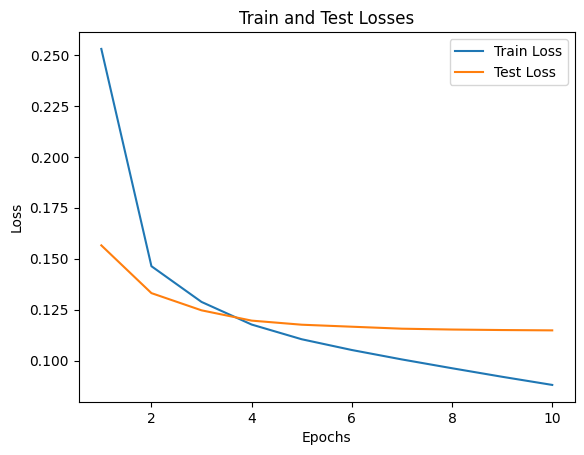

In [ ]:
# Convert the main_list to a NumPy array for efficient calculations
trainlosses_array = np.array(average_train_losses)
testlosses_array = np.array(average_test_losses)

# Calculate the average along the first axis (axis=0) to get the average of each element position
train_avg_across_runs = np.mean(trainlosses_array, axis=0)
test_avg_across_runs = np.mean(testlosses_array, axis=0)
# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot train losses
plt.plot(epochs, train_avg_across_runs, label='Train Loss')
# Plot test losses
plt.plot(epochs, test_avg_across_runs, label='Test Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()  # Show legend

# Display the plot
plt.show()


In [ ]:
# Save model
torch.save(model.state_dict(), root_path+'final_models/vit_approach2_sel.pth')

Continue to train the classifier for 10 more epochs.
It starts to overfit so we dont save this result

In [ ]:
# Train the model
train_losses = []
test_losses = []
num_epochs = 10
batch_size = BATCH_SIZE

for epoch in range(num_epochs):
    running_train_loss = 0.0
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * batch_X.size(0)

    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(y_train_tensor)
    train_losses.append(epoch_train_loss)

    print(f"Epoch [{num_epochs+epoch+1}/{num_epochs+10}], Train Loss: {epoch_train_loss:.4f}")

    # Evaluation Loop
    running_test_loss = 0.0
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(X_test_tensor), batch_size):
            batch_X = X_test_tensor[i:i+batch_size]
            batch_y = y_test_tensor[i:i+batch_size]

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            running_test_loss += loss.item() * batch_X.size(0)

            # Convert predictions and labels to numpy arrays
            batch_preds = outputs.cpu().numpy()
            batch_labels = batch_y.cpu().numpy()

            all_preds.append(batch_preds)
            all_labels.append(batch_labels)

    #test_loss = running_test_loss / len(X_test_tensor)
    epoch_test_loss = running_test_loss / len(y_test_tensor)
    test_losses.append(epoch_test_loss)

    # Calculate accuracy and AUC ROC for the test set
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    all_pred_labels = (all_preds > 0.5).astype(int)
    test_accuracy = accuracy_score(all_labels, all_pred_labels)
    test_auc_roc = roc_auc_score(all_labels, all_preds)

    # Calculate F1-Score
    f1 = f1_score(all_labels, all_pred_labels, average='micro')

    print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC ROC: {test_auc_roc:.4f}, F1-Score : {f1:.4f}")

Epoch [11/20], Train Loss: 0.0844
Test Loss: 0.1123, Test Accuracy: 0.7435, Test AUC ROC: 0.9216, F1-Score : 0.7913
Epoch [12/20], Train Loss: 0.0809
Test Loss: 0.1122, Test Accuracy: 0.7453, Test AUC ROC: 0.9207, F1-Score : 0.7932
Epoch [13/20], Train Loss: 0.0774
Test Loss: 0.1126, Test Accuracy: 0.7401, Test AUC ROC: 0.9200, F1-Score : 0.7854
Epoch [14/20], Train Loss: 0.0736
Test Loss: 0.1129, Test Accuracy: 0.7401, Test AUC ROC: 0.9196, F1-Score : 0.7909
Epoch [15/20], Train Loss: 0.0701
Test Loss: 0.1136, Test Accuracy: 0.7367, Test AUC ROC: 0.9191, F1-Score : 0.7867
Epoch [16/20], Train Loss: 0.0665
Test Loss: 0.1144, Test Accuracy: 0.7332, Test AUC ROC: 0.9188, F1-Score : 0.7854
Epoch [17/20], Train Loss: 0.0629
Test Loss: 0.1153, Test Accuracy: 0.7315, Test AUC ROC: 0.9178, F1-Score : 0.7835
Epoch [18/20], Train Loss: 0.0589
Test Loss: 0.1160, Test Accuracy: 0.7298, Test AUC ROC: 0.9172, F1-Score : 0.7835
Epoch [19/20], Train Loss: 0.0553
Test Loss: 0.1169, Test Accuracy: 0.72

In [ ]:
# Train the model
num_epochs = 10
batch_size = BATCH_SIZE

# Initialize lists to store metrics over 10 runs
average_train_losses = []
average_test_losses = []
average_accuracies = []
average_f1_scores = []
average_auc_rocs = []

for run in range(10):  # Perform 10 runs
    train_losses = []
    test_losses = []
    accuracies = []
    f1_scores = []
    auc_rocs = []
    # Initialize the model
    model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))
    # Define loss and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    print(f"Run : {run+1}")
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * batch_X.size(0)

        # Calculate average training loss for the epoch
        epoch_train_loss = running_train_loss / len(y_train_tensor)
        train_losses.append(epoch_train_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}")

        # Evaluation Loop
        running_test_loss = 0.0
        all_preds = []
        all_labels = []
        model.eval()
        with torch.no_grad():
            for i in range(0, len(X_test_tensor), batch_size):
                batch_X = X_test_tensor[i:i+batch_size]
                batch_y = y_test_tensor[i:i+batch_size]

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                running_test_loss += loss.item() * batch_X.size(0)

                # Convert predictions and labels to numpy arrays
                batch_preds = outputs.cpu().numpy()
                batch_labels = batch_y.cpu().numpy()

                all_preds.append(batch_preds)
                all_labels.append(batch_labels)

        #test_loss = running_test_loss / len(X_test_tensor)
        epoch_test_loss = running_test_loss / len(y_test_tensor)
        test_losses.append(epoch_test_loss)

        # Calculate accuracy and AUC ROC for the test set
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        all_pred_labels = (all_preds > 0.5).astype(int)
        test_accuracy = accuracy_score(all_labels, all_pred_labels)
        test_auc_roc = roc_auc_score(all_labels, all_preds)

        # Calculate F1-Score
        f1 = f1_score(all_labels, all_pred_labels, average='micro')

        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC ROC: {test_auc_roc:.4f}, F1-Score : {f1:.4f}")

    # At the end of each run, append metrics to the respective lists
    average_train_losses.append(train_losses)
    average_test_losses.append(test_losses)
    average_accuracies.append(test_accuracy)
    average_f1_scores.append(f1)
    average_auc_rocs.append(test_auc_roc)


# Calculate the average and standard deviation for each metric
avg_train_loss = np.mean(average_train_losses)
std_train_loss = np.std(average_train_losses)
avg_test_loss = np.mean(average_test_losses)
std_test_loss = np.std(average_test_losses)
avg_accuracy = np.mean(average_accuracies)
std_accuracy = np.std(average_accuracies)
avg_f1_score = np.mean(average_f1_scores)
std_f1_score = np.std(average_f1_scores)
avg_auc_roc = np.mean(average_auc_rocs)
std_auc_roc = np.std(average_auc_rocs)

# Print the average and standard deviation values
print(f"Average Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f} ± {std_f1_score:.4f}")
print(f"Average AUC ROC: {avg_auc_roc:.4f} ± {std_auc_roc:.4f}")

Run : 1
Epoch [1/10], Train Loss: 0.1581
Test Loss: 0.1233, Test Accuracy: 0.7194, Test AUC ROC: 0.9090, F1-Score : 0.7784
Epoch [2/10], Train Loss: 0.1193
Test Loss: 0.1195, Test Accuracy: 0.7126, Test AUC ROC: 0.9149, F1-Score : 0.7736
Epoch [3/10], Train Loss: 0.1083
Test Loss: 0.1167, Test Accuracy: 0.7194, Test AUC ROC: 0.9189, F1-Score : 0.7826
Epoch [4/10], Train Loss: 0.0991
Test Loss: 0.1160, Test Accuracy: 0.7246, Test AUC ROC: 0.9207, F1-Score : 0.7881
Epoch [5/10], Train Loss: 0.0917
Test Loss: 0.1157, Test Accuracy: 0.7177, Test AUC ROC: 0.9229, F1-Score : 0.7790
Epoch [6/10], Train Loss: 0.0850
Test Loss: 0.1148, Test Accuracy: 0.7212, Test AUC ROC: 0.9242, F1-Score : 0.7814
Epoch [7/10], Train Loss: 0.0786
Test Loss: 0.1153, Test Accuracy: 0.7315, Test AUC ROC: 0.9240, F1-Score : 0.7864
Epoch [8/10], Train Loss: 0.0733
Test Loss: 0.1153, Test Accuracy: 0.7229, Test AUC ROC: 0.9236, F1-Score : 0.7805
Epoch [9/10], Train Loss: 0.0683
Test Loss: 0.1155, Test Accuracy: 0.724

## Varying hidden layers

### 2 FC

In [ ]:
# Define your neural network architecture
class MultiLabelClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiLabelClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Create the model
model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Convert X_train and y_train to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Train the model
num_epochs = 10
batch_size = BATCH_SIZE

# Initialize lists to store metrics over 10 runs
average_train_losses = []
average_test_losses = []
average_accuracies = []
average_f1_scores = []
average_auc_rocs = []

for run in range(10):  # Perform 10 runs
    train_losses = []
    test_losses = []
    accuracies = []
    f1_scores = []
    auc_rocs = []
    # Initialize the model
    model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))
    # Define loss and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    print(f"Run : {run+1}")
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * batch_X.size(0)

        # Calculate average training loss for the epoch
        epoch_train_loss = running_train_loss / len(y_train_tensor)
        train_losses.append(epoch_train_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}")

        # Evaluation Loop
        running_test_loss = 0.0
        all_preds = []
        all_labels = []
        model.eval()
        with torch.no_grad():
            for i in range(0, len(X_test_tensor), batch_size):
                batch_X = X_test_tensor[i:i+batch_size]
                batch_y = y_test_tensor[i:i+batch_size]

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                running_test_loss += loss.item() * batch_X.size(0)

                # Convert predictions and labels to numpy arrays
                batch_preds = outputs.cpu().numpy()
                batch_labels = batch_y.cpu().numpy()

                all_preds.append(batch_preds)
                all_labels.append(batch_labels)

        #test_loss = running_test_loss / len(X_test_tensor)
        epoch_test_loss = running_test_loss / len(y_test_tensor)
        test_losses.append(epoch_test_loss)

        # Calculate accuracy and AUC ROC for the test set
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        all_pred_labels = (all_preds > 0.5).astype(int)
        test_accuracy = accuracy_score(all_labels, all_pred_labels)
        test_auc_roc = roc_auc_score(all_labels, all_preds)

        # Calculate F1-Score
        f1 = f1_score(all_labels, all_pred_labels, average='micro')

        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC ROC: {test_auc_roc:.4f}, F1-Score : {f1:.4f}")

    # At the end of each run, append metrics to the respective lists
    average_train_losses.append(train_losses)
    average_test_losses.append(test_losses)
    average_accuracies.append(test_accuracy)
    average_f1_scores.append(f1)
    average_auc_rocs.append(test_auc_roc)


# Calculate the average and standard deviation for each metric
avg_train_loss = np.mean(average_train_losses)
std_train_loss = np.std(average_train_losses)
avg_test_loss = np.mean(average_test_losses)
std_test_loss = np.std(average_test_losses)
avg_accuracy = np.mean(average_accuracies)
std_accuracy = np.std(average_accuracies)
avg_f1_score = np.mean(average_f1_scores)
std_f1_score = np.std(average_f1_scores)
avg_auc_roc = np.mean(average_auc_rocs)
std_auc_roc = np.std(average_auc_rocs)

# Print the average and standard deviation values
print(f"Average Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f} ± {std_f1_score:.4f}")
print(f"Average AUC ROC: {avg_auc_roc:.4f} ± {std_auc_roc:.4f}")

Run : 1
Epoch [1/10], Train Loss: 0.1758
Test Loss: 0.1328, Test Accuracy: 0.7074, Test AUC ROC: 0.8988, F1-Score : 0.7598
Epoch [2/10], Train Loss: 0.1220
Test Loss: 0.1227, Test Accuracy: 0.7177, Test AUC ROC: 0.9042, F1-Score : 0.7722
Epoch [3/10], Train Loss: 0.1112
Test Loss: 0.1194, Test Accuracy: 0.7143, Test AUC ROC: 0.9089, F1-Score : 0.7776
Epoch [4/10], Train Loss: 0.1034
Test Loss: 0.1182, Test Accuracy: 0.7229, Test AUC ROC: 0.9123, F1-Score : 0.7807
Epoch [5/10], Train Loss: 0.0966
Test Loss: 0.1170, Test Accuracy: 0.7263, Test AUC ROC: 0.9120, F1-Score : 0.7802
Epoch [6/10], Train Loss: 0.0908
Test Loss: 0.1164, Test Accuracy: 0.7298, Test AUC ROC: 0.9112, F1-Score : 0.7815
Epoch [7/10], Train Loss: 0.0855
Test Loss: 0.1163, Test Accuracy: 0.7332, Test AUC ROC: 0.9107, F1-Score : 0.7842
Epoch [8/10], Train Loss: 0.0807
Test Loss: 0.1164, Test Accuracy: 0.7315, Test AUC ROC: 0.9121, F1-Score : 0.7826
Epoch [9/10], Train Loss: 0.0762
Test Loss: 0.1159, Test Accuracy: 0.729

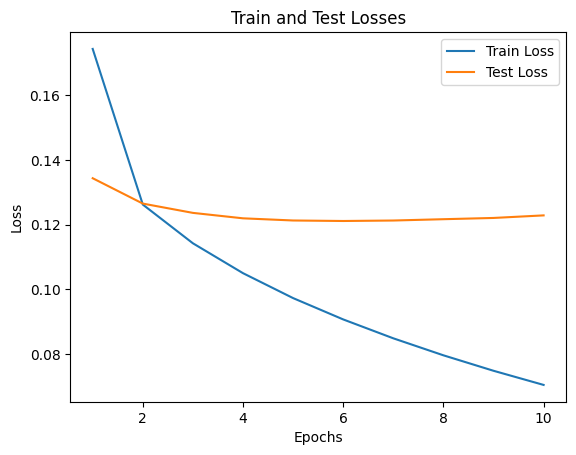

In [ ]:
# Convert the main_list to a NumPy array for efficient calculations
trainlosses_array = np.array(average_train_losses)
testlosses_array = np.array(average_test_losses)

# Calculate the average along the first axis (axis=0) to get the average of each element position
train_avg_across_runs = np.mean(trainlosses_array, axis=0)
test_avg_across_runs = np.mean(testlosses_array, axis=0)
# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot train losses
plt.plot(epochs, train_avg_across_runs, label='Train Loss')
# Plot test losses
plt.plot(epochs, test_avg_across_runs, label='Test Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()  # Show legend

# Display the plot
plt.show()


### 3 FC

In [ ]:
# Define your neural network architecture
class MultiLabelClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiLabelClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Create the model
model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Convert X_train and y_train to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Train the model
num_epochs = 10
batch_size = BATCH_SIZE

# Initialize lists to store metrics over 10 runs
average_train_losses = []
average_test_losses = []
average_accuracies = []
average_f1_scores = []
average_auc_rocs = []

for run in range(10):  # Perform 10 runs
    train_losses = []
    test_losses = []
    accuracies = []
    f1_scores = []
    auc_rocs = []
    # Initialize the model
    model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))
    # Define loss and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    print(f"Run : {run+1}")
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * batch_X.size(0)

        # Calculate average training loss for the epoch
        epoch_train_loss = running_train_loss / len(y_train_tensor)
        train_losses.append(epoch_train_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}")

        # Evaluation Loop
        running_test_loss = 0.0
        all_preds = []
        all_labels = []
        model.eval()
        with torch.no_grad():
            for i in range(0, len(X_test_tensor), batch_size):
                batch_X = X_test_tensor[i:i+batch_size]
                batch_y = y_test_tensor[i:i+batch_size]

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                running_test_loss += loss.item() * batch_X.size(0)

                # Convert predictions and labels to numpy arrays
                batch_preds = outputs.cpu().numpy()
                batch_labels = batch_y.cpu().numpy()

                all_preds.append(batch_preds)
                all_labels.append(batch_labels)

        #test_loss = running_test_loss / len(X_test_tensor)
        epoch_test_loss = running_test_loss / len(y_test_tensor)
        test_losses.append(epoch_test_loss)

        # Calculate accuracy and AUC ROC for the test set
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        all_pred_labels = (all_preds > 0.5).astype(int)
        test_accuracy = accuracy_score(all_labels, all_pred_labels)
        test_auc_roc = roc_auc_score(all_labels, all_preds)

        # Calculate F1-Score
        f1 = f1_score(all_labels, all_pred_labels, average='micro')

        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC ROC: {test_auc_roc:.4f}, F1-Score : {f1:.4f}")

    # At the end of each run, append metrics to the respective lists
    average_train_losses.append(train_losses)
    average_test_losses.append(test_losses)
    average_accuracies.append(test_accuracy)
    average_f1_scores.append(f1)
    average_auc_rocs.append(test_auc_roc)


# Calculate the average and standard deviation for each metric
avg_train_loss = np.mean(average_train_losses)
std_train_loss = np.std(average_train_losses)
avg_test_loss = np.mean(average_test_losses)
std_test_loss = np.std(average_test_losses)
avg_accuracy = np.mean(average_accuracies)
std_accuracy = np.std(average_accuracies)
avg_f1_score = np.mean(average_f1_scores)
std_f1_score = np.std(average_f1_scores)
avg_auc_roc = np.mean(average_auc_rocs)
std_auc_roc = np.std(average_auc_rocs)

# Print the average and standard deviation values
print(f"Average Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f} ± {std_f1_score:.4f}")
print(f"Average AUC ROC: {avg_auc_roc:.4f} ± {std_auc_roc:.4f}")

Run : 1
Epoch [1/10], Train Loss: 0.3279
Test Loss: 0.1940, Test Accuracy: 0.6592, Test AUC ROC: 0.8968, F1-Score : 0.7201
Epoch [2/10], Train Loss: 0.1596
Test Loss: 0.1406, Test Accuracy: 0.6850, Test AUC ROC: 0.9014, F1-Score : 0.7564
Epoch [3/10], Train Loss: 0.1286
Test Loss: 0.1256, Test Accuracy: 0.7040, Test AUC ROC: 0.9070, F1-Score : 0.7713
Epoch [4/10], Train Loss: 0.1168
Test Loss: 0.1203, Test Accuracy: 0.7160, Test AUC ROC: 0.9079, F1-Score : 0.7813
Epoch [5/10], Train Loss: 0.1098
Test Loss: 0.1182, Test Accuracy: 0.7298, Test AUC ROC: 0.9090, F1-Score : 0.7881
Epoch [6/10], Train Loss: 0.1044
Test Loss: 0.1168, Test Accuracy: 0.7298, Test AUC ROC: 0.9106, F1-Score : 0.7895
Epoch [7/10], Train Loss: 0.0998
Test Loss: 0.1161, Test Accuracy: 0.7298, Test AUC ROC: 0.9111, F1-Score : 0.7908
Epoch [8/10], Train Loss: 0.0956
Test Loss: 0.1158, Test Accuracy: 0.7315, Test AUC ROC: 0.9117, F1-Score : 0.7931
Epoch [9/10], Train Loss: 0.0917
Test Loss: 0.1155, Test Accuracy: 0.731

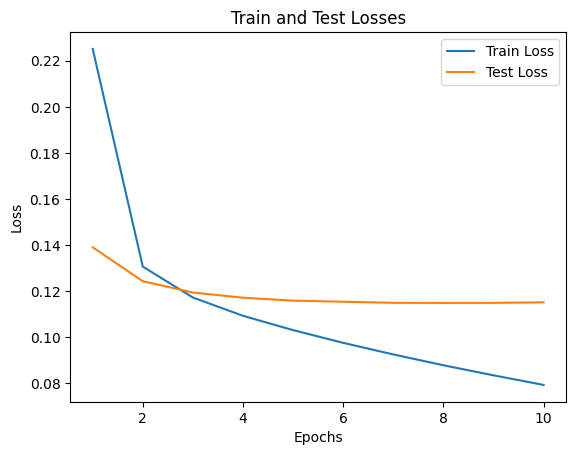

In [ ]:
# Convert the main_list to a NumPy array for efficient calculations
trainlosses_array = np.array(average_train_losses)
testlosses_array = np.array(average_test_losses)

# Calculate the average along the first axis (axis=0) to get the average of each element position
train_avg_across_runs = np.mean(trainlosses_array, axis=0)
test_avg_across_runs = np.mean(testlosses_array, axis=0)
# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot train losses
plt.plot(epochs, train_avg_across_runs, label='Train Loss')
# Plot test losses
plt.plot(epochs, test_avg_across_runs, label='Test Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()  # Show legend

# Display the plot
plt.show()


### 5 FC

In [ ]:
# Define your neural network architecture
class MultiLabelClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiLabelClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        x = self.sigmoid(x)
        return x

# Create the model
model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Convert X_train and y_train to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [ ]:
# Train the model
num_epochs = 10
batch_size = BATCH_SIZE

# Initialize lists to store metrics over 10 runs
average_train_losses = []
average_test_losses = []
average_accuracies = []
average_f1_scores = []
average_auc_rocs = []

for run in range(10):  # Perform 10 runs
    train_losses = []
    test_losses = []
    accuracies = []
    f1_scores = []
    auc_rocs = []
    # Initialize the model
    model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))
    # Define loss and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    print(f"Run : {run+1}")
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * batch_X.size(0)

        # Calculate average training loss for the epoch
        epoch_train_loss = running_train_loss / len(y_train_tensor)
        train_losses.append(epoch_train_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}")

        # Evaluation Loop
        running_test_loss = 0.0
        all_preds = []
        all_labels = []
        model.eval()
        with torch.no_grad():
            for i in range(0, len(X_test_tensor), batch_size):
                batch_X = X_test_tensor[i:i+batch_size]
                batch_y = y_test_tensor[i:i+batch_size]

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                running_test_loss += loss.item() * batch_X.size(0)

                # Convert predictions and labels to numpy arrays
                batch_preds = outputs.cpu().numpy()
                batch_labels = batch_y.cpu().numpy()

                all_preds.append(batch_preds)
                all_labels.append(batch_labels)

        #test_loss = running_test_loss / len(X_test_tensor)
        epoch_test_loss = running_test_loss / len(y_test_tensor)
        test_losses.append(epoch_test_loss)

        # Calculate accuracy and AUC ROC for the test set
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        all_pred_labels = (all_preds > 0.5).astype(int)
        test_accuracy = accuracy_score(all_labels, all_pred_labels)
        test_auc_roc = roc_auc_score(all_labels, all_preds)

        # Calculate F1-Score
        f1 = f1_score(all_labels, all_pred_labels, average='micro')

        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC ROC: {test_auc_roc:.4f}, F1-Score : {f1:.4f}")

    # At the end of each run, append metrics to the respective lists
    average_train_losses.append(train_losses)
    average_test_losses.append(test_losses)
    average_accuracies.append(test_accuracy)
    average_f1_scores.append(f1)
    average_auc_rocs.append(test_auc_roc)


# Calculate the average and standard deviation for each metric
avg_train_loss = np.mean(average_train_losses)
std_train_loss = np.std(average_train_losses)
avg_test_loss = np.mean(average_test_losses)
std_test_loss = np.std(average_test_losses)
avg_accuracy = np.mean(average_accuracies)
std_accuracy = np.std(average_accuracies)
avg_f1_score = np.mean(average_f1_scores)
std_f1_score = np.std(average_f1_scores)
avg_auc_roc = np.mean(average_auc_rocs)
std_auc_roc = np.std(average_auc_rocs)

# Print the average and standard deviation values
print(f"Average Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f} ± {std_f1_score:.4f}")
print(f"Average AUC ROC: {avg_auc_roc:.4f} ± {std_auc_roc:.4f}")

Run : 1
Epoch [1/10], Train Loss: 0.2507
Test Loss: 0.1448, Test Accuracy: 0.6506, Test AUC ROC: 0.8930, F1-Score : 0.7207
Epoch [2/10], Train Loss: 0.1410
Test Loss: 0.1302, Test Accuracy: 0.6816, Test AUC ROC: 0.9062, F1-Score : 0.7496
Epoch [3/10], Train Loss: 0.1286
Test Loss: 0.1243, Test Accuracy: 0.7057, Test AUC ROC: 0.9074, F1-Score : 0.7641
Epoch [4/10], Train Loss: 0.1209
Test Loss: 0.1205, Test Accuracy: 0.7126, Test AUC ROC: 0.9078, F1-Score : 0.7691
Epoch [5/10], Train Loss: 0.1150
Test Loss: 0.1186, Test Accuracy: 0.7194, Test AUC ROC: 0.9075, F1-Score : 0.7723
Epoch [6/10], Train Loss: 0.1101
Test Loss: 0.1169, Test Accuracy: 0.7246, Test AUC ROC: 0.9083, F1-Score : 0.7786
Epoch [7/10], Train Loss: 0.1055
Test Loss: 0.1160, Test Accuracy: 0.7298, Test AUC ROC: 0.9133, F1-Score : 0.7791
Epoch [8/10], Train Loss: 0.1008
Test Loss: 0.1146, Test Accuracy: 0.7315, Test AUC ROC: 0.9163, F1-Score : 0.7815
Epoch [9/10], Train Loss: 0.0962
Test Loss: 0.1136, Test Accuracy: 0.728

### 6 FC

In [ ]:
# Define your neural network architecture
class MultiLabelClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiLabelClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        x = self.sigmoid(x)
        return x

# Create the model
model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Convert X_train and y_train to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [ ]:
# Train the model
num_epochs = 10
batch_size = BATCH_SIZE

# Initialize lists to store metrics over 10 runs
average_train_losses = []
average_test_losses = []
average_accuracies = []
average_f1_scores = []
average_auc_rocs = []

for run in range(10):  # Perform 10 runs
    train_losses = []
    test_losses = []
    accuracies = []
    f1_scores = []
    auc_rocs = []
    # Initialize the model
    model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))
    # Define loss and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    print(f"Run : {run+1}")
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * batch_X.size(0)

        # Calculate average training loss for the epoch
        epoch_train_loss = running_train_loss / len(y_train_tensor)
        train_losses.append(epoch_train_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}")

        # Evaluation Loop
        running_test_loss = 0.0
        all_preds = []
        all_labels = []
        model.eval()
        with torch.no_grad():
            for i in range(0, len(X_test_tensor), batch_size):
                batch_X = X_test_tensor[i:i+batch_size]
                batch_y = y_test_tensor[i:i+batch_size]

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                running_test_loss += loss.item() * batch_X.size(0)

                # Convert predictions and labels to numpy arrays
                batch_preds = outputs.cpu().numpy()
                batch_labels = batch_y.cpu().numpy()

                all_preds.append(batch_preds)
                all_labels.append(batch_labels)

        #test_loss = running_test_loss / len(X_test_tensor)
        epoch_test_loss = running_test_loss / len(y_test_tensor)
        test_losses.append(epoch_test_loss)

        # Calculate accuracy and AUC ROC for the test set
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        all_pred_labels = (all_preds > 0.5).astype(int)
        test_accuracy = accuracy_score(all_labels, all_pred_labels)
        test_auc_roc = roc_auc_score(all_labels, all_preds)

        # Calculate F1-Score
        f1 = f1_score(all_labels, all_pred_labels, average='micro')

        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC ROC: {test_auc_roc:.4f}, F1-Score : {f1:.4f}")

    # At the end of each run, append metrics to the respective lists
    average_train_losses.append(train_losses)
    average_test_losses.append(test_losses)
    average_accuracies.append(test_accuracy)
    average_f1_scores.append(f1)
    average_auc_rocs.append(test_auc_roc)


# Calculate the average and standard deviation for each metric
avg_train_loss = np.mean(average_train_losses)
std_train_loss = np.std(average_train_losses)
avg_test_loss = np.mean(average_test_losses)
std_test_loss = np.std(average_test_losses)
avg_accuracy = np.mean(average_accuracies)
std_accuracy = np.std(average_accuracies)
avg_f1_score = np.mean(average_f1_scores)
std_f1_score = np.std(average_f1_scores)
avg_auc_roc = np.mean(average_auc_rocs)
std_auc_roc = np.std(average_auc_rocs)

# Print the average and standard deviation values
print(f"Average Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f} ± {std_f1_score:.4f}")
print(f"Average AUC ROC: {avg_auc_roc:.4f} ± {std_auc_roc:.4f}")

### Classifier trained on CNN features

In [ ]:
# Reshape to flatten the CNN features
cnn_features_reshaped = all_feature_cnn.reshape(all_feature_cnn.shape[0], -1)

feature_array = cnn_features_reshaped.cpu().numpy()
label_array = cnn_labels.cpu().numpy()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_array, label_array, test_size=0.2, random_state=42)


In [ ]:
# Define your neural network architecture
class MultiLabelClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiLabelClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)  # Output layer
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

# Create the model
model = MultiLabelClassifier(len(X_train[0]), len(y_train[0]))

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert X_train and y_train to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Train the model
num_epochs = 10
batch_size = BATCH_SIZE

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    running_train_loss = 0.0
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * batch_X.size(0)

    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(y_train_tensor)
    train_losses.append(epoch_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}")

    # Evaluation Loop
    running_test_loss = 0.0
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(X_test_tensor), batch_size):
            batch_X = X_test_tensor[i:i+batch_size]
            batch_y = y_test_tensor[i:i+batch_size]

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            running_test_loss += loss.item() * batch_X.size(0)

            # Convert predictions and labels to numpy arrays
            batch_preds = outputs.cpu().numpy()
            batch_labels = batch_y.cpu().numpy()

            all_preds.append(batch_preds)
            all_labels.append(batch_labels)

    epoch_test_loss = running_test_loss / len(y_test_tensor)
    test_losses.append(epoch_test_loss)

    # Calculate accuracy and AUC ROC for the test set
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    test_auc_roc = roc_auc_score(all_labels, all_preds)

    all_pred_labels = (all_preds > 0.5).astype(int)
    test_accuracy = accuracy_score(all_labels, all_pred_labels)

    # Calculate F1-Score (micro-averaged)
    f1 = f1_score(all_labels, all_pred_labels, average='micro')

    print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC ROC: {test_auc_roc:.4f}, F1-Score : {f1:.4f}")

Epoch [1/10], Train Loss: 0.2398
Test Loss: 0.2091, Test Accuracy: 0.6041, Test AUC ROC: 0.6277, F1-Score : 0.6010
Epoch [2/10], Train Loss: 0.2088
Test Loss: 0.2041, Test Accuracy: 0.5645, Test AUC ROC: 0.6364, F1-Score : 0.5860
Epoch [3/10], Train Loss: 0.2010
Test Loss: 0.2051, Test Accuracy: 0.5508, Test AUC ROC: 0.6434, F1-Score : 0.5808
Epoch [4/10], Train Loss: 0.1984
Test Loss: 0.2059, Test Accuracy: 0.5473, Test AUC ROC: 0.6369, F1-Score : 0.5785
Epoch [5/10], Train Loss: 0.1943
Test Loss: 0.2045, Test Accuracy: 0.5800, Test AUC ROC: 0.6420, F1-Score : 0.5947
Epoch [6/10], Train Loss: 0.1915
Test Loss: 0.2052, Test Accuracy: 0.5852, Test AUC ROC: 0.6377, F1-Score : 0.5969
Epoch [7/10], Train Loss: 0.1880
Test Loss: 0.2067, Test Accuracy: 0.5714, Test AUC ROC: 0.6609, F1-Score : 0.5925
Epoch [8/10], Train Loss: 0.1836
Test Loss: 0.2068, Test Accuracy: 0.5594, Test AUC ROC: 0.6479, F1-Score : 0.5829
Epoch [9/10], Train Loss: 0.1822
Test Loss: 0.2078, Test Accuracy: 0.5473, Test 

In [ ]:
# Calculate Precision and Recall
val_precision = precision_score(all_labels, all_pred_labels, average='micro')
val_recall = recall_score(all_labels, all_pred_labels, average='micro')
print(val_precision)
print(val_recall)

0.6966731898238747
0.536144578313253


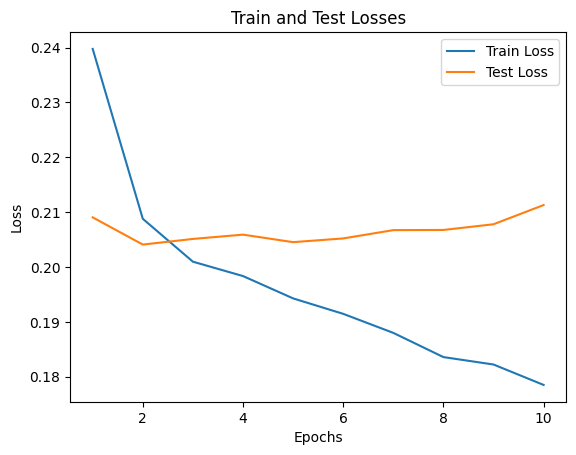

In [ ]:
# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot train losses
plt.plot(epochs, train_losses, label='Train Loss')
# Plot test losses
plt.plot(epochs, test_losses, label='Test Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()  # Show legend

# Display the plot
plt.show()

In [ ]:
# Save model
torch.save(model.state_dict(), root_path+'final_models/mobilenet_approach2_sel.pth')

# Evaluate

In [ ]:
# Load test data for Classifier (Already used fine-tuned ViT to extract features)
test_features_vit = torch.load(root_path+'features/test_features_new2.pt')
test_labels_vit = torch.load(root_path+'features/test_labels_new2.pt')
#test_features_vit = X_test
#test_labels = y_test

In [ ]:
# Flatten and shape them for classifier
test_features_reshaped = test_features_vit.reshape(test_features_vit.shape[0], -1)

all_features = torch.cat((vit_features_reshaped, cnn_features_reshaped), dim=1)
# Convert feature_tensor and label_tensor to NumPy arrays
feature_array = all_features.cpu().numpy()
label_array = vit_labels.cpu().numpy()

NameError: ignored

In [ ]:
test_features_vit.shape

torch.Size([6439, 195, 768])

In [ ]:
# Randomly sample from Test Set to evaluate models

# Number of rows to sample
num_samples = 500

# Randomly sample indices for the subset
sample_indices = torch.randperm(test_features_vit.size(0))[:num_samples]

# Access the sampled subset using the indices
test_features = test_features_vit[sample_indices]
test_labels = test_labels_vit[sample_indices]

print(test_features.shape)  # Should print torch.Size([500, 195, 768])
print(test_labels.shape)  # Should also print torch.Size([500, 195, 768])


torch.Size([500, 195, 768])
torch.Size([500, 12])


In [ ]:
# Define your neural network architecture
class MultiLabelClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiLabelClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)  # Output layer
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

In [ ]:
#Load model and prepare test set

# Reshape test samples to (num_samples, 195 * 768)
X_test_reshaped = test_features.reshape(test_features.shape[0], -1)

# Convert X_test_reshaped to PyTorch tensor
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)

# Create an instance of your MultiLabelClassifier
input_size = len(X_test_tensor[0])
output_size = len(test_labels[0])
model = MultiLabelClassifier(input_size, output_size)

# Load the saved model weights (state_dict)
model.load_state_dict(torch.load(root_path+'final_models/vit_approach2_sel.pth'))

# Set the model to evaluation mode
model.eval()

<ipython-input-42-0ca61c37a51f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)


MultiLabelClassifier(
  (fc1): Linear(in_features=149760, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=12, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [ ]:
# Make predictions on the test data
with torch.no_grad():
    test_outputs = model(X_test_tensor)

# Convert test_outputs tensor to a numpy array
test_predictions = test_outputs.numpy()

output_size = test_labels.shape[1]
roc_auc_scores = []
for i in range(output_size):
    roc_auc_scores.append(roc_auc_score(test_labels[:, i], test_predictions[:, i]))

# Print the ROC AUC scores for each class
for i, score in enumerate(roc_auc_scores):
    print(f"Class {i}: ROC AUC = {score:.4f}")


Class 0: ROC AUC = 0.6700
Class 1: ROC AUC = 0.7617
Class 2: ROC AUC = 0.6773
Class 3: ROC AUC = 0.6230
Class 4: ROC AUC = 0.7661
Class 5: ROC AUC = 0.6531
Class 6: ROC AUC = 0.6886
Class 7: ROC AUC = 0.7876
Class 8: ROC AUC = 0.7048
Class 9: ROC AUC = 0.6857
Class 10: ROC AUC = 0.6771
Class 11: ROC AUC = 0.5337


In [ ]:
from sklearn.metrics import accuracy_score

# Convert predicted probabilities to binary labels
test_pred_labels = (test_predictions > 0.5).astype(int)
# Calculate accuracy for each class
accuracy_scores = []
for i in range(output_size):
    accuracy_scores.append(accuracy_score(test_labels[:, i], test_pred_labels[:, i]))

# Print the accuracy scores for each class
for i, score in enumerate(accuracy_scores):
    print(f"Class {i}: Accuracy = {score:.4f}")


Class 0: Accuracy = 0.8740
Class 1: Accuracy = 0.9320
Class 2: Accuracy = 0.9500
Class 3: Accuracy = 0.9920
Class 4: Accuracy = 0.8920
Class 5: Accuracy = 0.9820
Class 6: Accuracy = 0.8380
Class 7: Accuracy = 0.9600
Class 8: Accuracy = 0.6760
Class 9: Accuracy = 0.9560
Class 10: Accuracy = 0.9700
Class 11: Accuracy = 0.9760


In [ ]:
from sklearn.metrics import accuracy_score

# Calculate overall accuracy
overall_accuracy = accuracy_score(test_labels, test_pred_labels)

print(f"Overall Accuracy: {overall_accuracy:.4f}")

Overall Accuracy: 0.4920


In [ ]:
from sklearn.metrics import hamming_loss, jaccard_score, f1_score

# Calculate Hamming Loss
hamming_loss_value = hamming_loss(test_labels, test_pred_labels)
print(f"Hamming Loss: {hamming_loss_value:.4f}")

# Calculate Jaccard Score
jaccard_score_value = jaccard_score(test_labels, test_pred_labels, average='samples')  # 'samples' averages across all labels
print(f"Jaccard Score: {jaccard_score_value:.4f}")

# Calculate F1-Score (micro-averaged)
f1_micro = f1_score(test_labels, test_pred_labels, average='micro')
print(f"F1-Score (Micro): {f1_micro:.4f}")

# Calculate F1-Score (macro-averaged)
f1_macro = f1_score(test_labels, test_pred_labels, average='macro')
print(f"F1-Score (Macro): {f1_macro:.4f}")

Hamming Loss: 0.0767
Jaccard Score: 0.5297
F1-Score (Micro): 0.5512
F1-Score (Macro): 0.1871


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
